# Validating SCOOT Data with Video Counts

The City of Toronto uses the [SCOOT system](https://github.com/CityofToronto/bdit_data-sources/tree/master/volumes/scoot) for signal coordination. SCOOT is a dynamic signal control system that changes cycle time based on vehicle detections. This notebook explores the possibility of using SCOOT data for traffic volume counts.

Video cameras were set up at a few intersections to get counts every 20 seconds lane by lane. Vehicle detections from SCOOT comes in every signal cycle. Side by side volume comparisons are set up for both cycle-level aggregations and arbitrary aggregations on the same day at the same locations.

start_time_sec -> inclusive  
end_time_sec -> inclusive

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import sys
from pg import DB
import configparser

In [2]:
def aggregate_data(min_bins_start,df, volume):
    i = 1
    j = 1
    v = []
    for var in range(len(min_bins_start)-1):
        a = min_bins_start[var]
        b = min_bins_start[var+1]
        # i points to the scoot bin immediately before interested time period
        while df['seconds'].iloc[i] < a:
            i = i + 1
        i = i - 1
        # j points to the scoot bin immediately after interested time period
        while df['seconds'].iloc[j] < b and j!=len(df)-1:
            j = j + 1
        if j - i == 1: # [i,a,b,j]
            v.append(df[volume].iloc[i]/df['CycleTime'].iloc[i]*(b-a))
        elif j - i == 2: # [i,a,i+1(j-1),b,j]
            v.append(df[volume].iloc[i]*((df['seconds'].iloc[i+1]-a)/df['CycleTime'].iloc[i])+df[volume].iloc[j-1]*((b-df['seconds'].iloc[j-1])/df['CycleTime'].iloc[j-1]))
        else:   # [i,a,i+1,i+2,...,j-1,b,j]
            vt = 0
            for k in range(j-1-(i+1)):
                vt = vt + df[volume].iloc[i+k+1]
            v.append(vt+df[volume].iloc[i]*((df['seconds'].iloc[i+1]-a)/df['CycleTime'].iloc[i])+df[volume].iloc[j-1]*((b-df['seconds'].iloc[j-1])/df['CycleTime'].iloc[j-1]))
    return v


In [3]:
def aggregate_lanes(df,aggregation):
    cnt = 0
    for lst in aggregation:
        df['detector'+str(cnt)] = df[lst].sum(axis=1)
        cnt = cnt + 1
    return df

In [4]:
def add_y_eq_x(ax, label):
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, label = label)
    

In [6]:
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [7]:
centrelines = [3304786,446523,30018925,30018925,1147201,1147201,1147026,1147466,8540609,8571185,11466484,1141946]
dir_bins = [1,-1,1,-1,1,-1,1,1,1,-1,1,-1]
sdetectors = [['\'N12921J1\'','\'N12921J2\''],['\'N12931A1\'','\'N12931A2\''],['\'N12821C1\'','\'N12821C2\'','\'N12821C3\''],['\'N12851G1\'','\'N12851G2\''],['\'N30431K1\'','\'N30431K2\''],['\'N30421B1\'','\'N30421B2\''],['\'N30611K1\'','\'N30611K2\''],['\'N30311D1\'','\'N30311D2\''],['\'N21521K1\''],['\'N21521H1\''],['\'N21421D1\''],['\'N21311B1\'']]
locations = ['Don Mills NB N of Overlea','Don Mills SB S of Gateway','Don Mills NB N of Clock Tower','Don Mills SB S of Lawrence','Lake Shore EB E of Stadium','Lake Shore WB W of Bathurst','Lake Shore EB E of Spadina','Lake Shore EB E of Ontario Place','Bloor EB W of Castle Frank','Bloor WB E of Castle Frank','Bloor EB E of Church','Bloor WB W of Church']
aggregation = [[['lane1','lane2'],['lane3']],
               [['lane1','lane2'],['lane3']],
               [['lane1'],['lane2'],['lane3']],
               [['lane2','lane3'],['lane1']],
               [['lane1','lane2'],['lane3']],
               [['lane3'],['lane1','lane2']],
               [['lane1'],['lane2','lane3']],
               [['lane1'],['lane2','lane3']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']]]
colors = ['r','b','c','k']
det_lane = {'N12921J1':2,'N12921J2':1,'N12931A1':2,'N12931A2':1,'N12821C1':1,'N12821C2':1,'N12821C3':1,
                 'N12851G1':2,'N12851G2':1,'N30431K1':2,'N30431K2':1,'N30421B1':1,'N30421B2':2,'N30611K1':1,
                 'N30611K2':2,'N30311D1':1,'N30311D2':2,'N21521K1':2,'N21521H1':2,'N21421D1':2,'N21311B1':2}

In [8]:
scoot = pd.DataFrame(db.query('SELECT * FROM scoot.cycle_level_170419 WHERE detector IN (' + ','.join([y for x in sdetectors for y in x ]) + ')').getresult(), columns = ['count_date','count_time','detector','CycleTime','Volume','occupancy','seconds'])
video = pd.DataFrame(db.query('SELECT * FROM scoot.video_counts').getresult(), columns = ['time_start','time_end','lane1','lane2','lane3','Volume','centreline_id','dir_bin','count_date','seconds'])
video['CycleTime'] = 20

## 1. Aggregate Video Counts to Line up with SCOOT Cycles
Both time of day profiles and scatter plots are done here for each scoot detector. In the case when a detector spans two lanes, video counts will be aggregated to match up.

The plots can be zoomed in and out by changing the time scope at the beginning of the next code block. Changing the duration will change the zoom level of the time of day plots since the plot size is staying the same. 

Since video cameras are not necessarily placed right where the scoot loops are and there might be transmission delays in the SCOOT system, offsets are used to shift the video counts along the timeline in seconds. If there's a confirmed offset at one of the locations, changing the numbers below will fulfill the purpose.

Don Mills NB N of Overlea
Bins = SCOOT Cycles, Video Offset = 0 sec


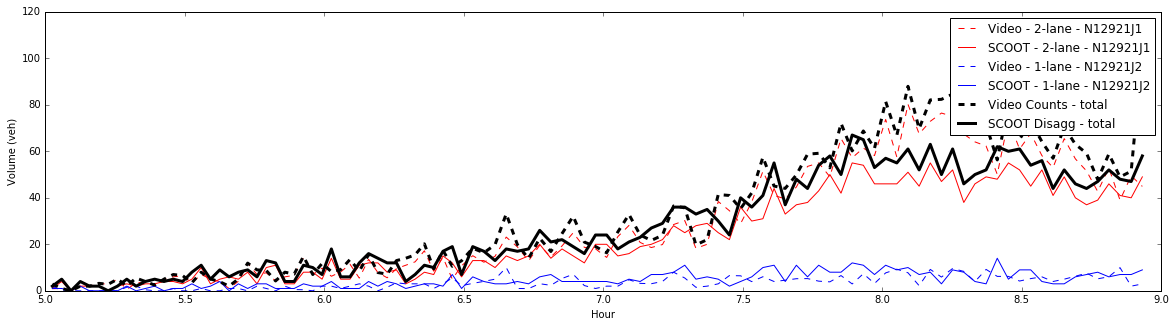

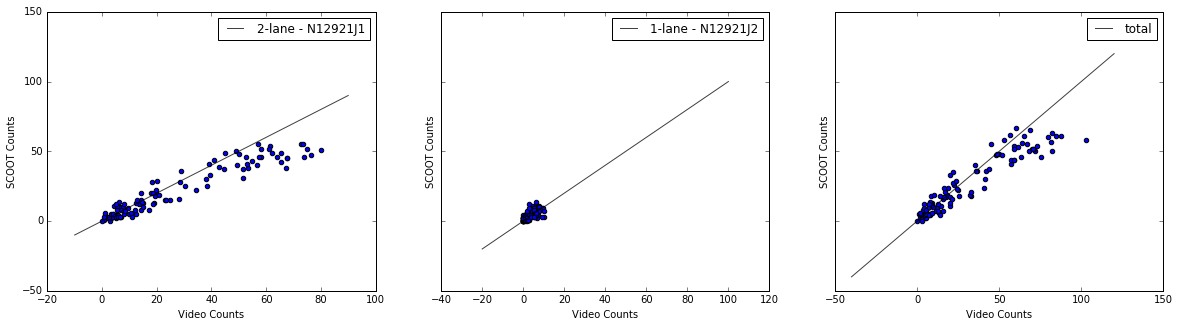

Don Mills SB S of Gateway
Bins = SCOOT Cycles, Video Offset = 0 sec


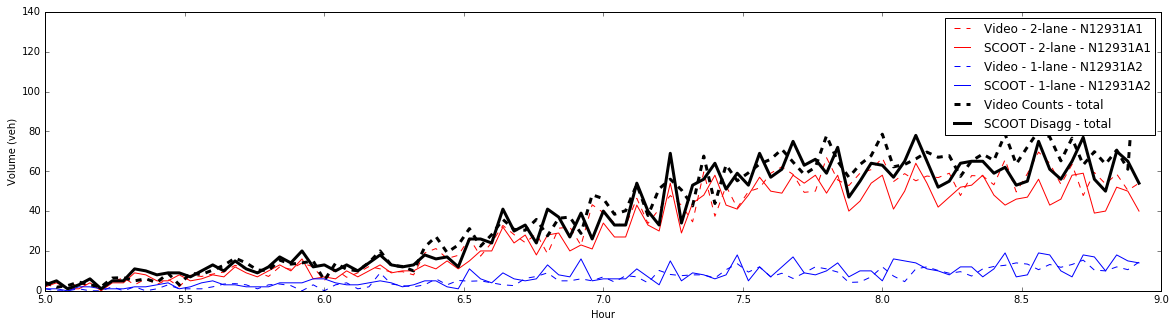

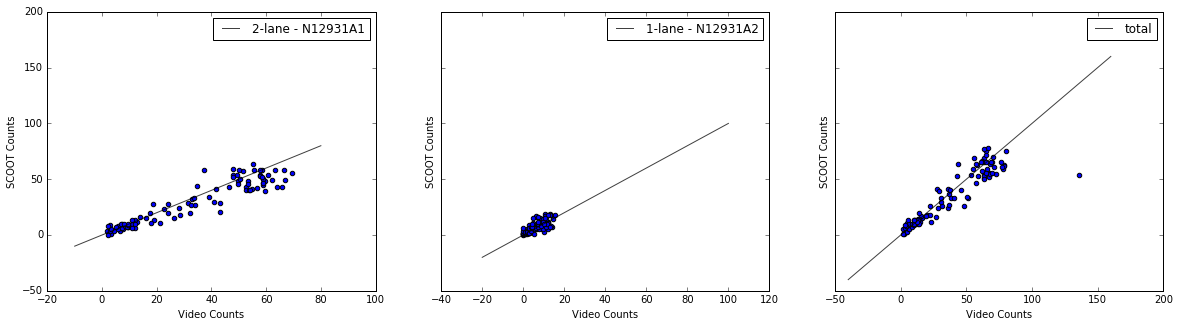

Don Mills NB N of Clock Tower
Bins = SCOOT Cycles, Video Offset = 0 sec


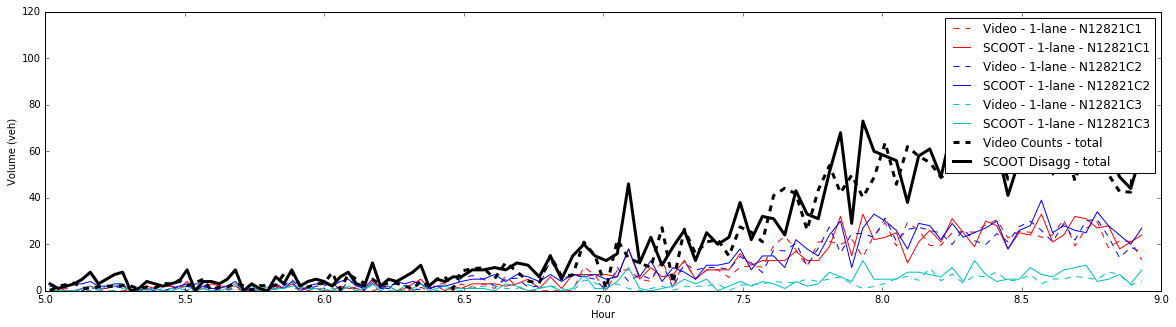

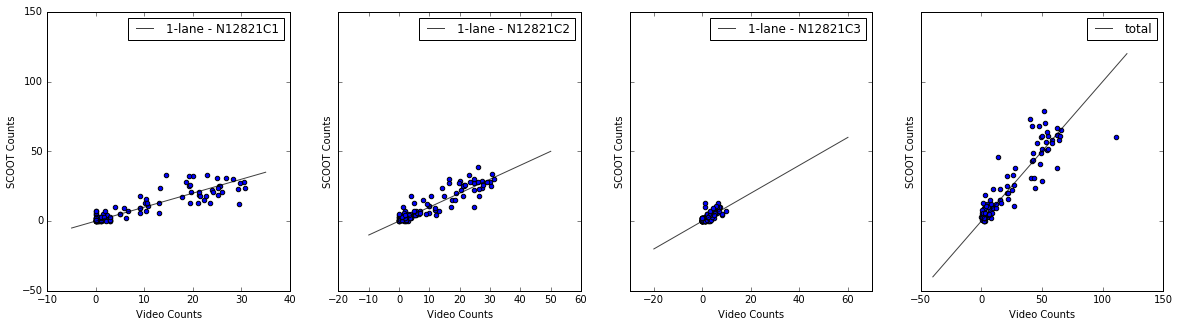

Don Mills SB S of Lawrence
Bins = SCOOT Cycles, Video Offset = 0 sec


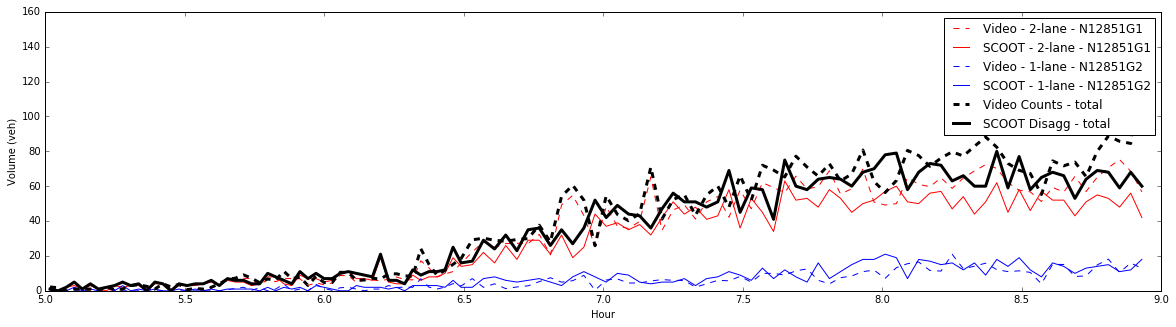

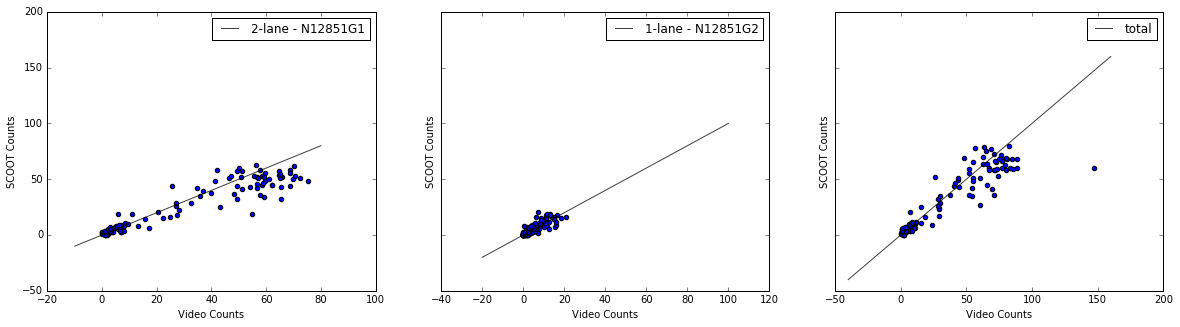

Lake Shore EB E of Stadium
Bins = SCOOT Cycles, Video Offset = 0 sec


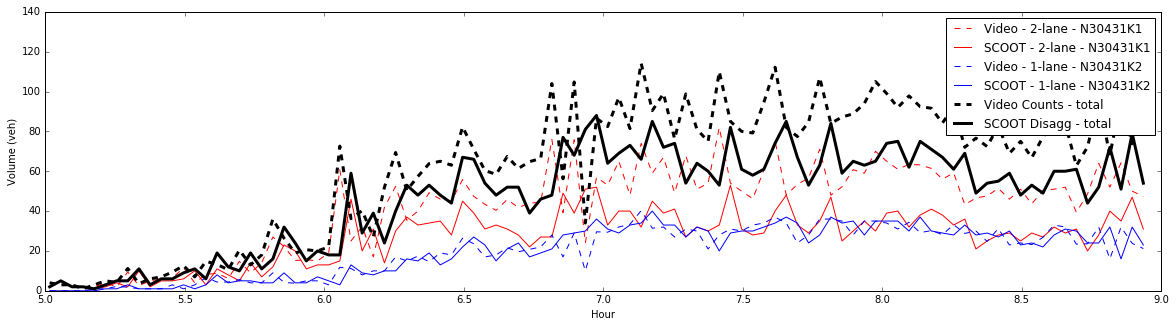

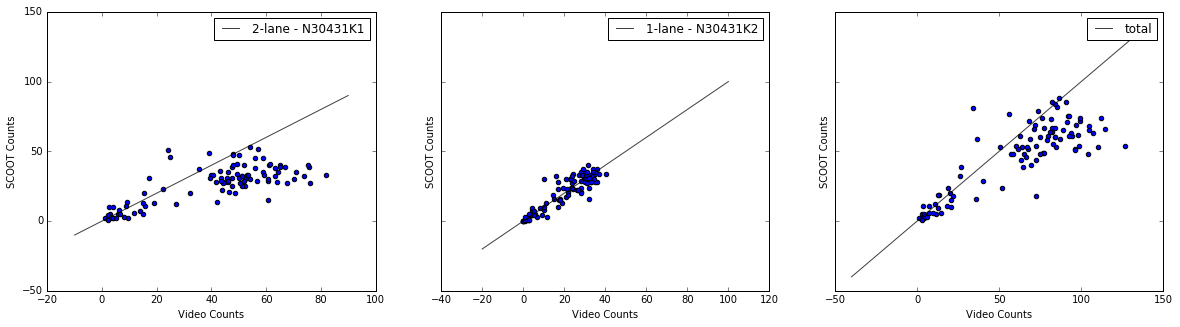

Lake Shore WB W of Bathurst
Bins = SCOOT Cycles, Video Offset = 0 sec


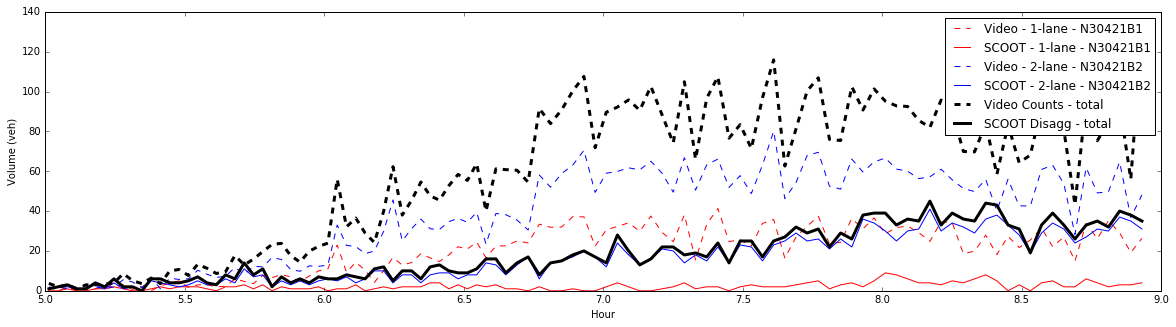

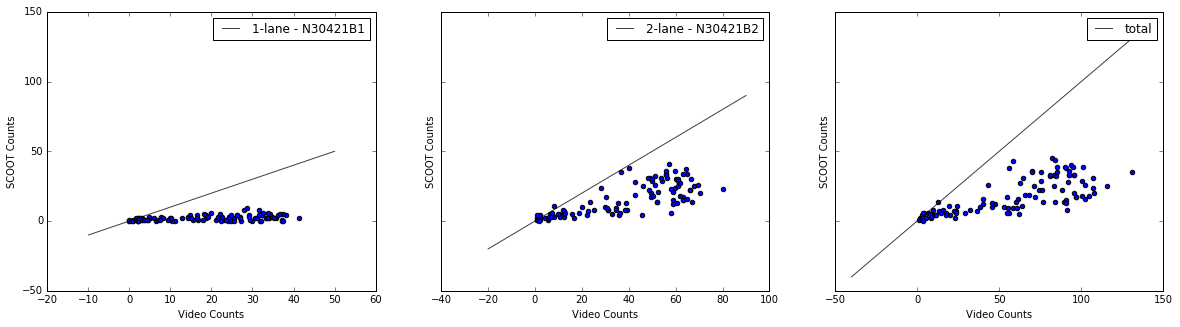

Lake Shore EB E of Spadina
Bins = SCOOT Cycles, Video Offset = 0 sec


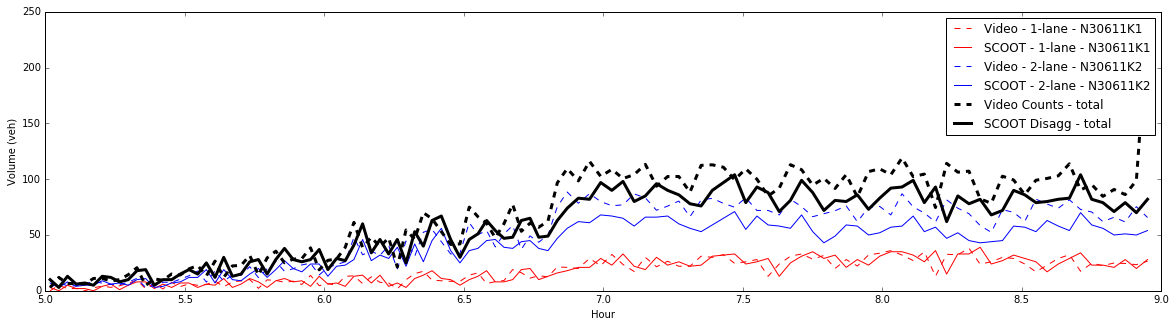

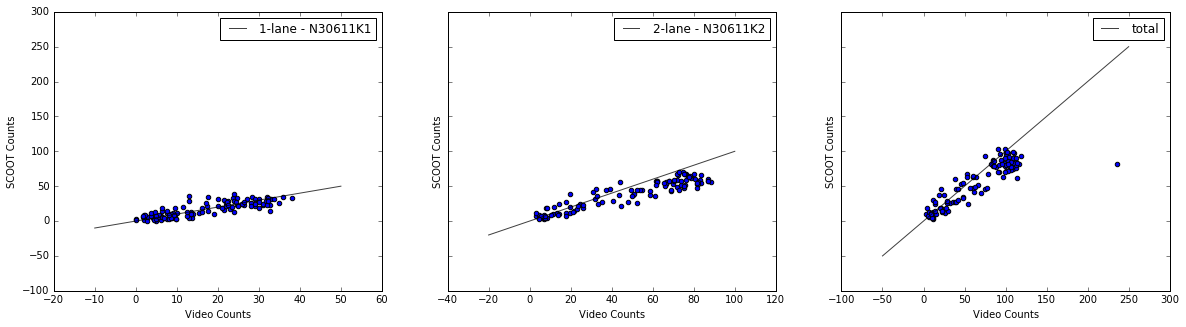

Lake Shore EB E of Ontario Place
Bins = SCOOT Cycles, Video Offset = 0 sec


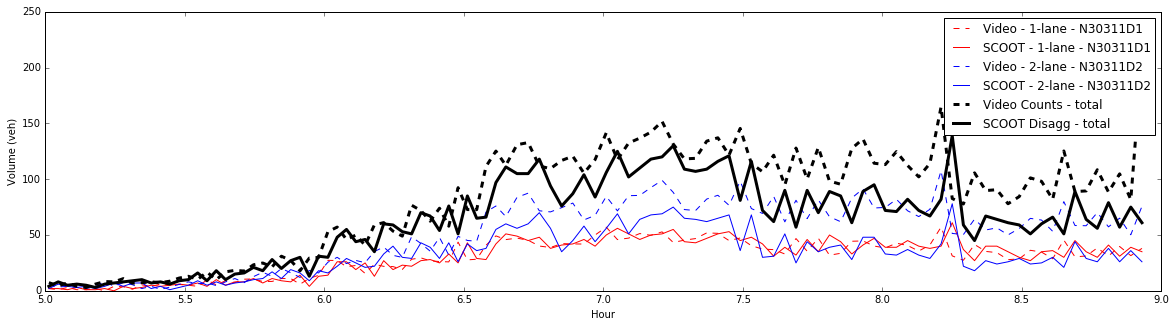

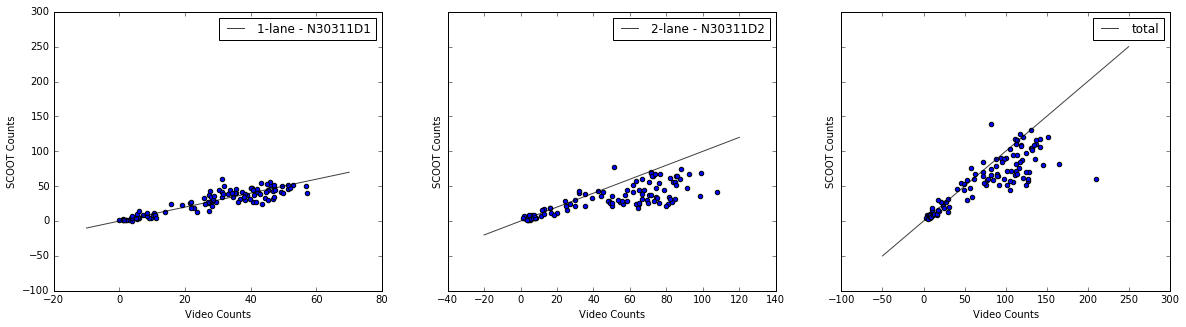

Bloor EB W of Castle Frank
Bins = SCOOT Cycles, Video Offset = 0 sec


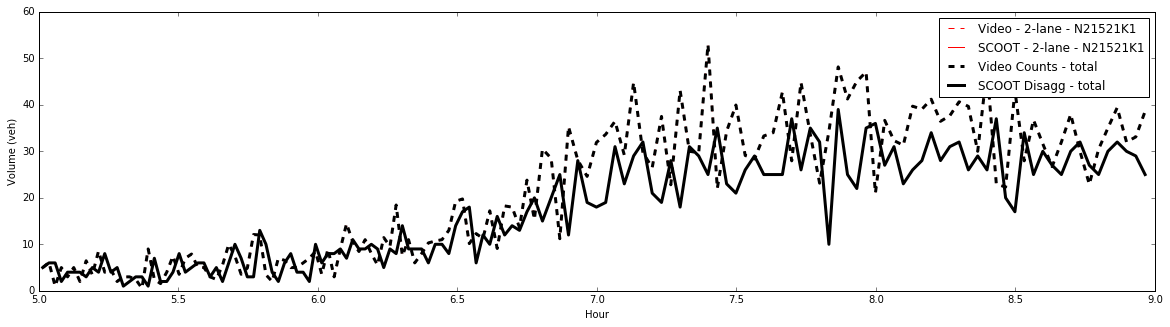

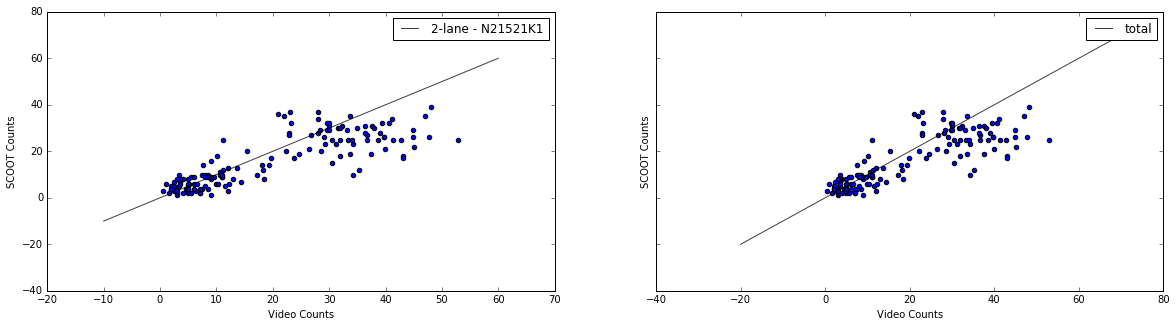

Bloor WB E of Castle Frank
Bins = SCOOT Cycles, Video Offset = 0 sec


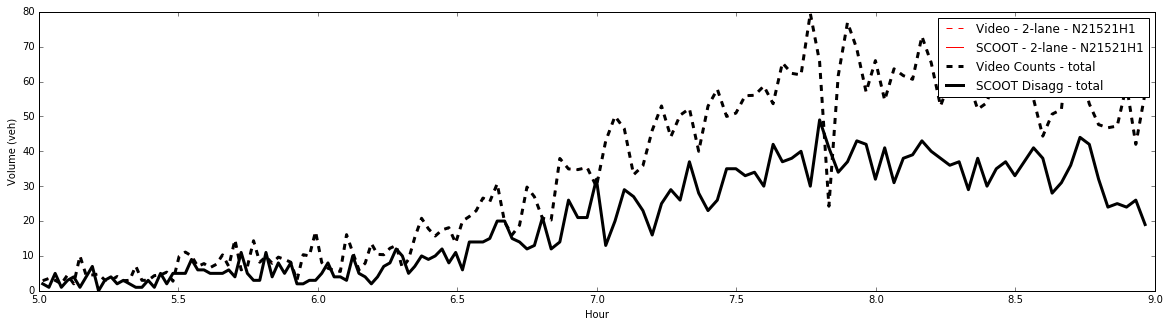

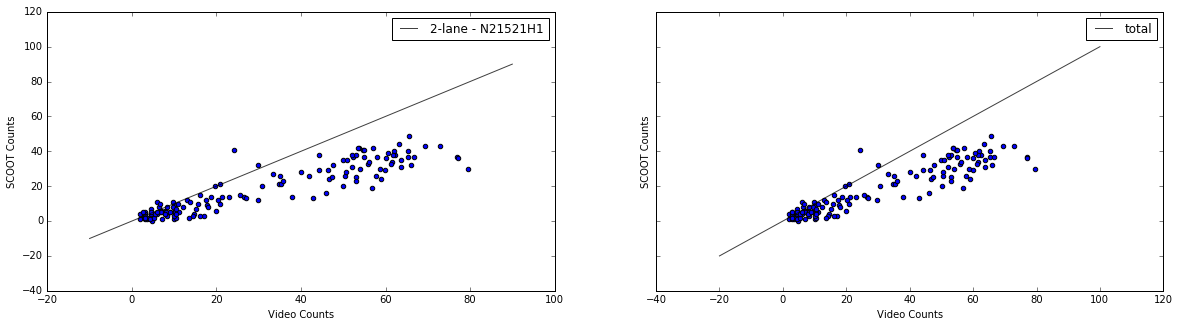

Bloor EB E of Church
Bins = SCOOT Cycles, Video Offset = 0 sec


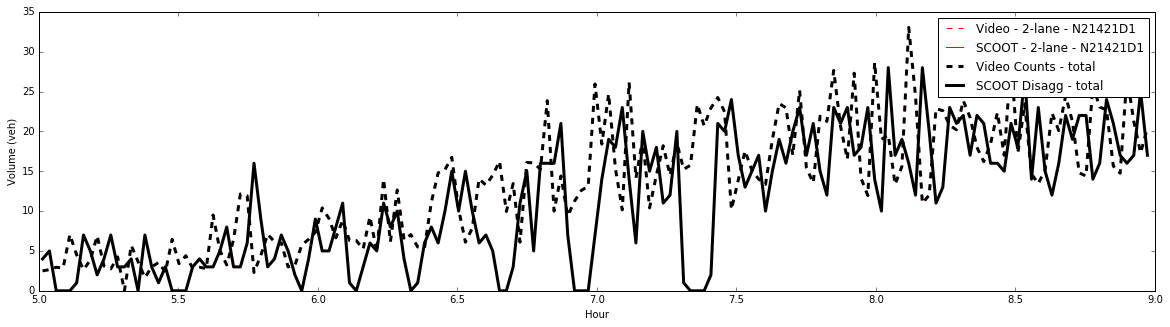

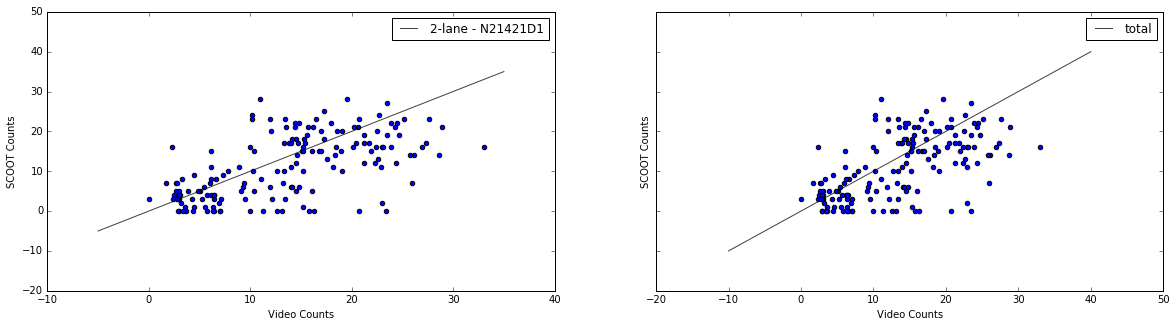

Bloor WB W of Church
Bins = SCOOT Cycles, Video Offset = 0 sec


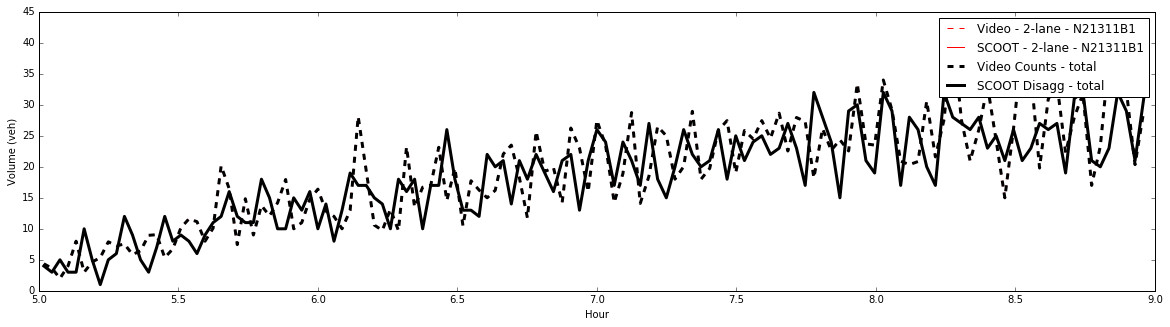

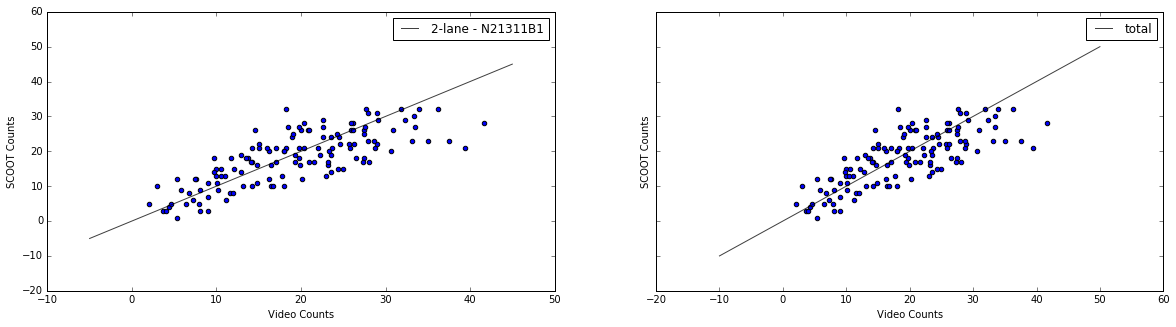

In [12]:
start_hour = 5
start_min = 0
start_sec = 0
end_hour = 8
end_min = 59
end_sec = 59

offsets = [0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(len(locations)):

    sdet = [x.strip('\'') for x in sdetectors[i]]
    tcl = centrelines[i]
    dir_bin = dir_bins[i]
    offset = offsets[i]
    
    print(locations[i])
    print('Bins = SCOOT Cycles, Video Offset =', offset, 'sec')

    fig,axx = plt.subplots(figsize=[20,5]) 
    
    start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
    end_time_sec = end_hour * 3600 + end_min * 60 + end_sec

    # Time and Location Filter
    s = scoot[(scoot['seconds']>=start_time_sec) & (scoot['seconds']+scoot['CycleTime']<=end_time_sec)].copy()
    r = video[(video['seconds']>=start_time_sec-offset) & (video['seconds']<=end_time_sec-offset) & (video['centreline_id']==tcl) & (video['dir_bin']==dir_bin)].copy()
    s = s[s['detector'].isin([x.strip('\'') for x in sdet])]
    
    # Aggregate individual detectors
    r = aggregate_lanes(r, aggregation[i])
    
    # Offset video 
    r['seconds']=r['seconds']+offset

    # Reset Index
    s.reset_index(inplace=True,drop=True)
    r.reset_index(inplace=True,drop=True)

    fig,(ax) = plt.subplots(1,len(sdet)+1,figsize=(20,5), sharey=True)
    # Plot Individual Detectors
    for det in range(len(sdet)):
        
        s0 = s[s['detector'] == sdet[det]]
        min_bins_start = list(s0['seconds'])
        min_bins_start.append(s0['seconds'].values[-1]+s0['CycleTime'].values[-1])

        v = aggregate_data(min_bins_start,r,'detector'+str(det))
        axx.plot([x/3600 for x in min_bins_start[:-1]],v,colors[det]+'--',label='Video - ' + str(det_lane[sdet[det]]) + '-lane - '+ sdet[det])
        axx.plot([x/3600 for x in min_bins_start[:-1]],s0['Volume'],colors[det],label='SCOOT - '+ str(det_lane[sdet[det]]) + '-lane - '+ sdet[det])
        ax[det].scatter(v,s0['Volume'],label=None)
        ax[det].set_xlabel('Video Counts')
        ax[det].set_ylabel('SCOOT Counts')
        add_y_eq_x(ax[det], str(det_lane[sdet[det]]) + '-lane - '+ sdet[det])
        ax[det].legend()
        
    # Plot Total
    s = s.groupby(['seconds'], as_index=False).sum()
    min_bins_start = list(s['seconds'])
    min_bins_start.append(s['seconds'].values[-1]+s['CycleTime'].values[-1])
    v = aggregate_data(min_bins_start,r,'Volume')
    det = det + 1
    axx.plot([x/3600 for x in min_bins_start[:-1]],v,colors[-1]+'--',label='Video Counts - total',linewidth=3)
    axx.plot([x/3600 for x in min_bins_start[:-1]],s['Volume'],colors[-1],label='SCOOT Disagg - total',linewidth=3)

    ax[det].scatter(v,s['Volume'],label=None)
    ax[det].set_xlabel('Video Counts')
    ax[det].set_ylabel('SCOOT Counts')
    add_y_eq_x(ax[det], 'total')
    ax[det].legend()
    
    axx.legend()
    axx.set_ylabel('Volume (veh)')
    axx.set_xlabel('Hour')
    plt.show()


## Observations
1. Video counts and SCOOOT counts line up well with increasing volumes. 
    - This can be attributed to our assumption that in each 20s interval, vehicles arrive uniformly, which is not the case. With a small number of vehicles passing by, this can have a huge influence on the alignment. 
    
2. 1-lane detectors follow the line y=x closely whereas as volumes increase, 2-lane detectors starts to flatten. 
    - SCOOT data is translated from on-off signals sent from the loop; when volumes get large, vehicles arrive on the loops concurrently get missed. As volumes get large (typically 50 vehicles per cycle), the 2-lane detectors start to under-count.

3. The detectors at Lake Shore WB W of Bathurst is faulty.

## 2. Aggregate to Arbitarry Levels

Most of our analysis is done in 15min aggregations. Therefore, we want to see how good the data is for aggregations of a longer time interval. Theoretically, longer time intervals should smooth out the signal timing issue mentioned above.

Similarly, varying the start and end times helps with zooming time of day profiles and offsets can be applied if need be. Multiple bin aggregations can be supplied to test out the effects of different aggregation levels. 

Don Mills NB N of Overlea
binsize = 900 seconds, Video Offset = 0 sec


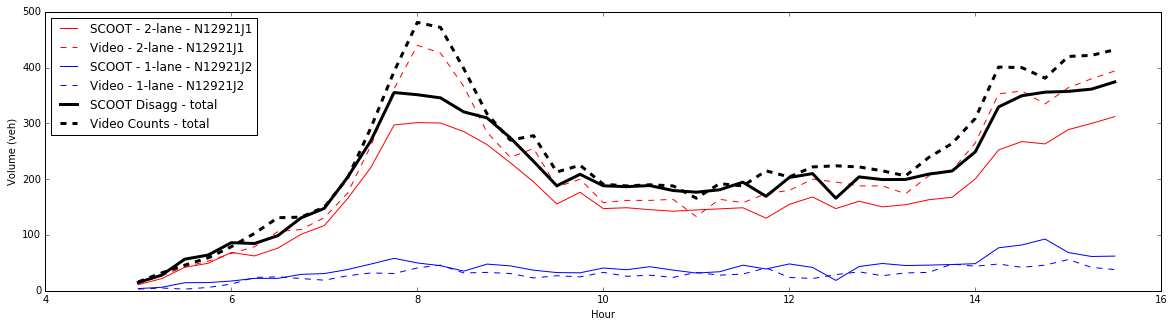

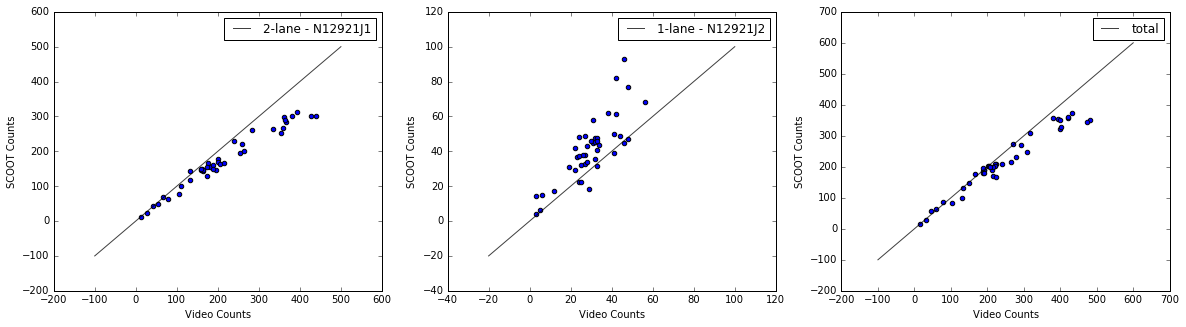

Don Mills SB S of Gateway
binsize = 900 seconds, Video Offset = 0 sec


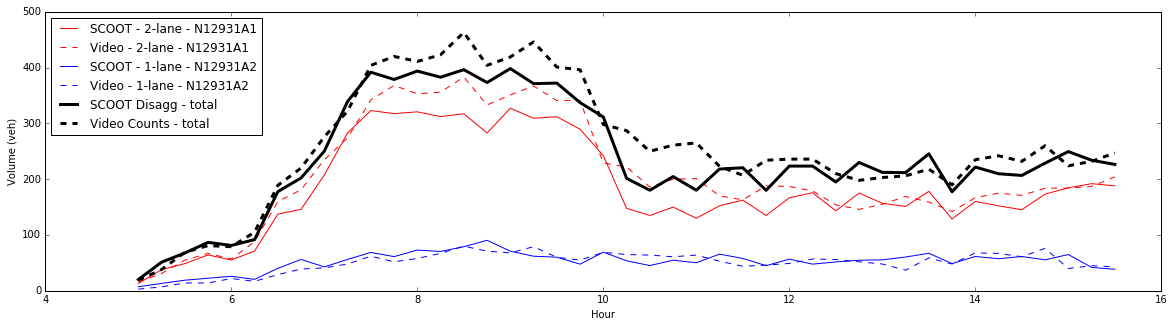

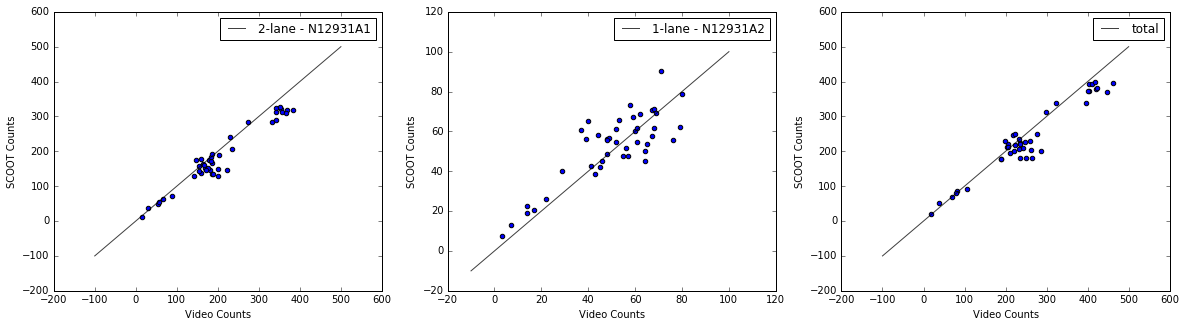

Don Mills NB N of Clock Tower
binsize = 900 seconds, Video Offset = 0 sec


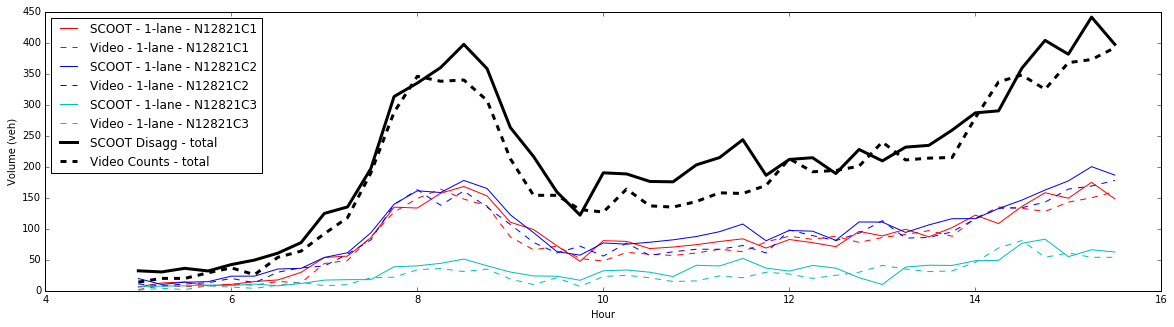

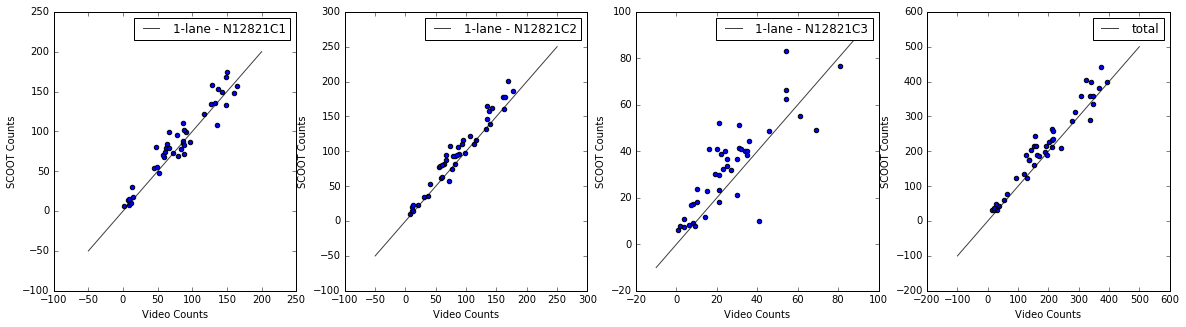

Don Mills SB S of Lawrence
binsize = 900 seconds, Video Offset = 0 sec


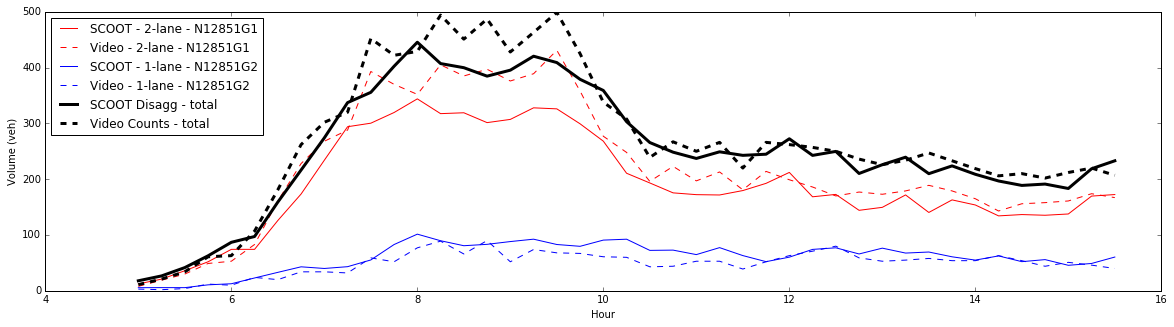

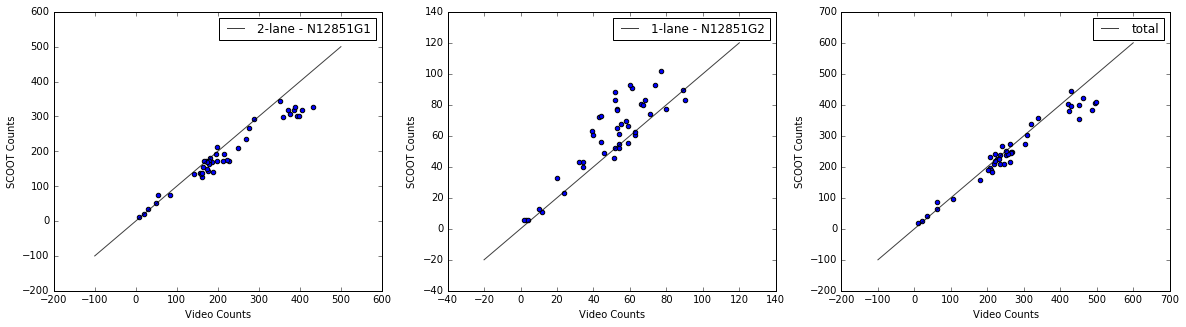

Lake Shore EB E of Stadium
binsize = 900 seconds, Video Offset = 0 sec


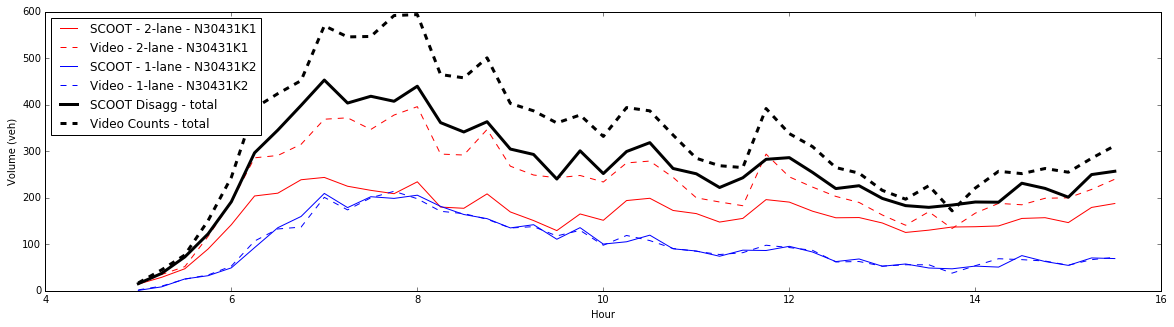

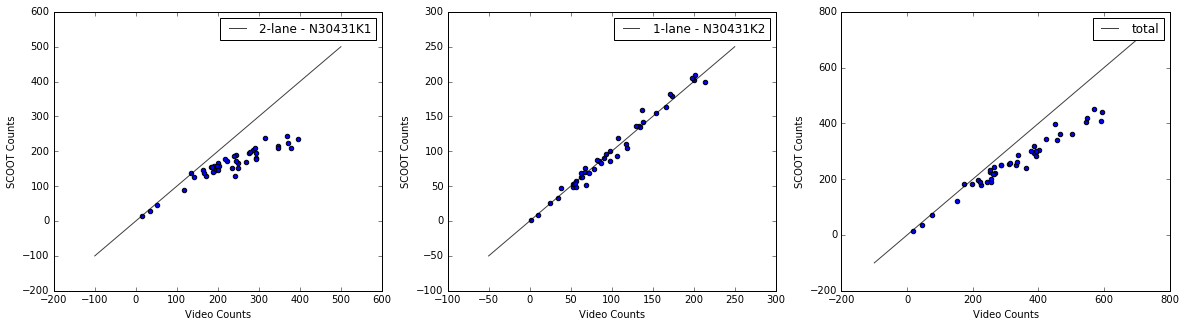

Lake Shore WB W of Bathurst
binsize = 900 seconds, Video Offset = 0 sec


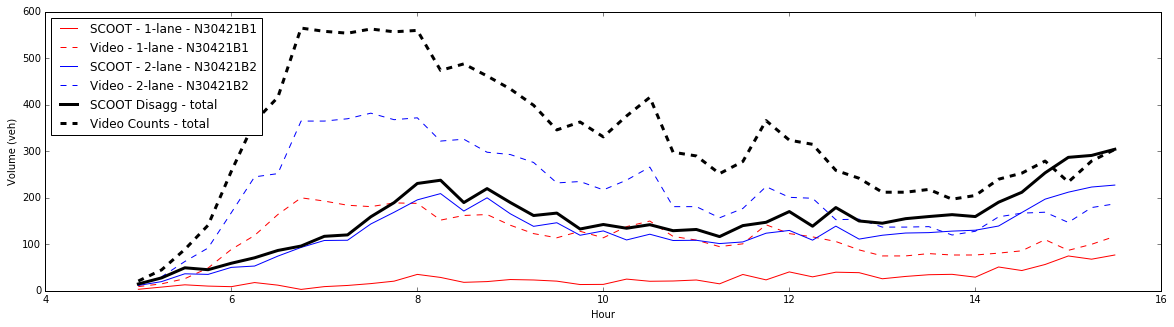

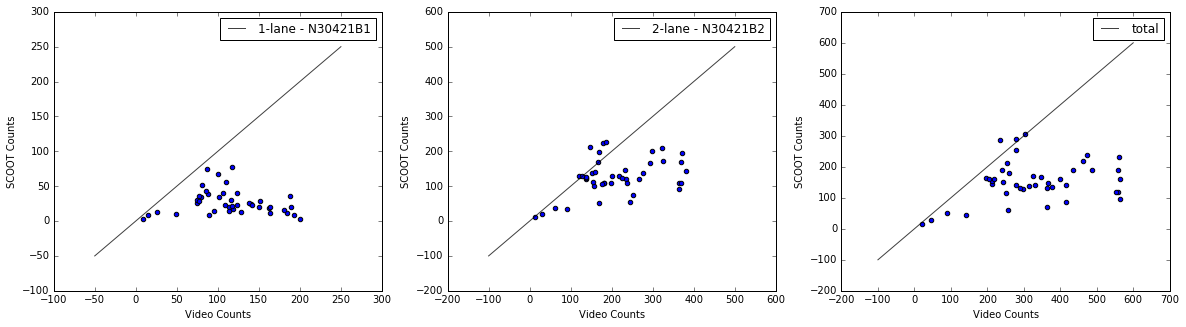

Lake Shore EB E of Spadina
binsize = 900 seconds, Video Offset = 0 sec


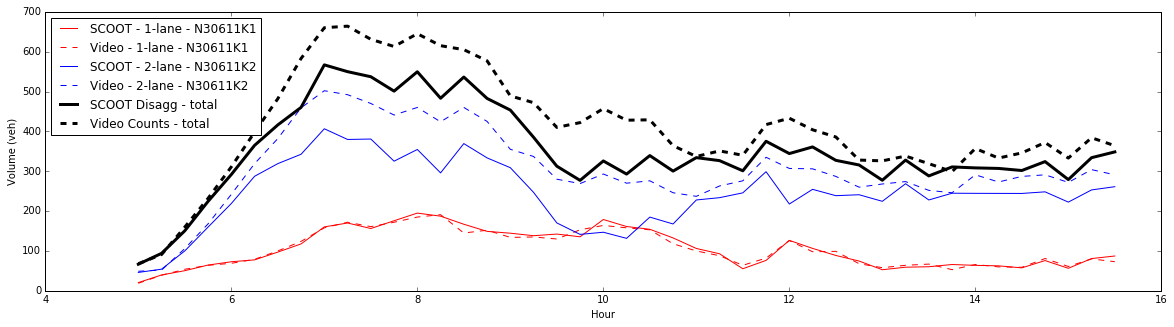

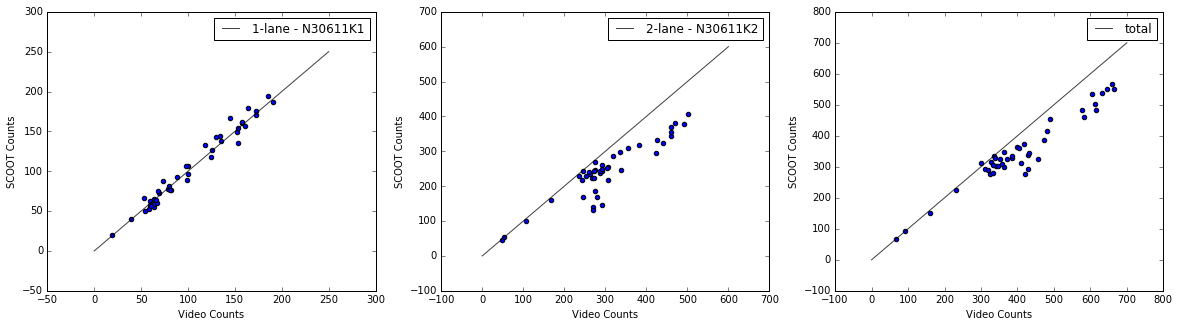

Lake Shore EB E of Ontario Place
binsize = 900 seconds, Video Offset = 0 sec


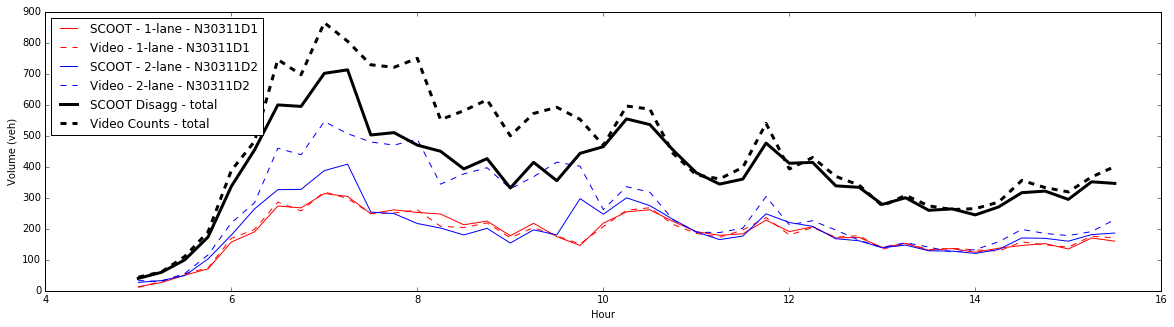

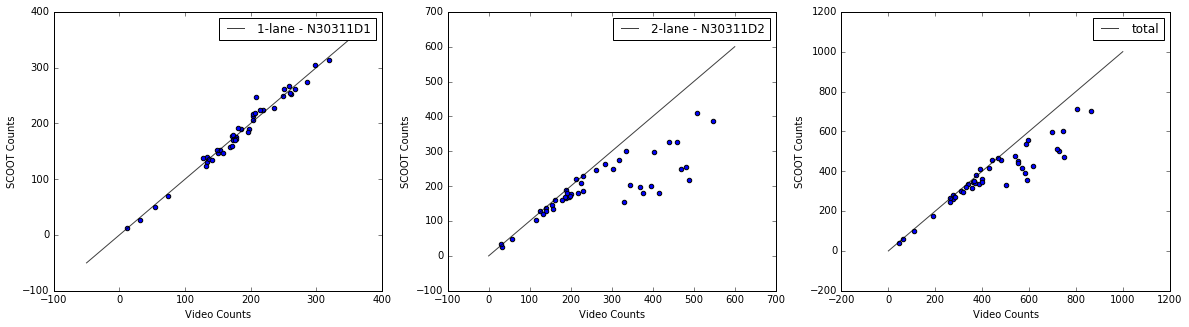

Bloor EB W of Castle Frank
binsize = 900 seconds, Video Offset = 0 sec


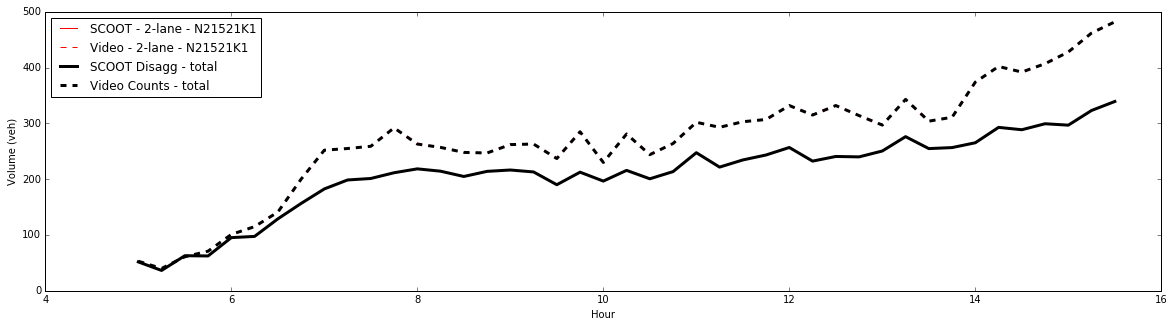

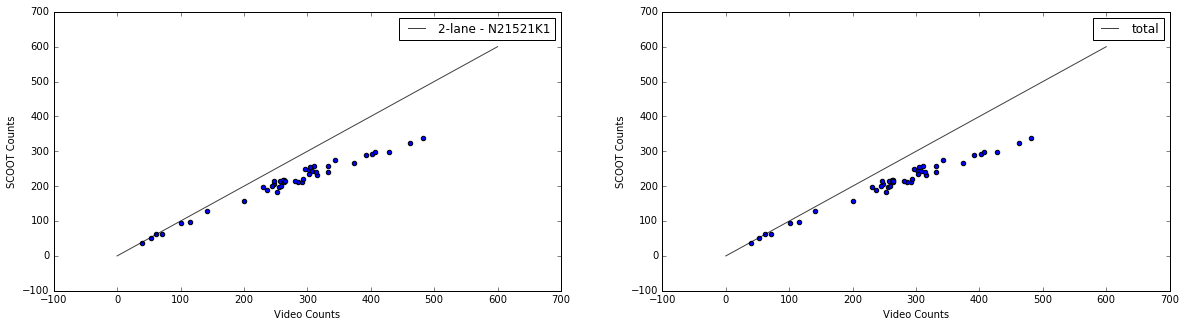

Bloor WB E of Castle Frank
binsize = 900 seconds, Video Offset = 0 sec


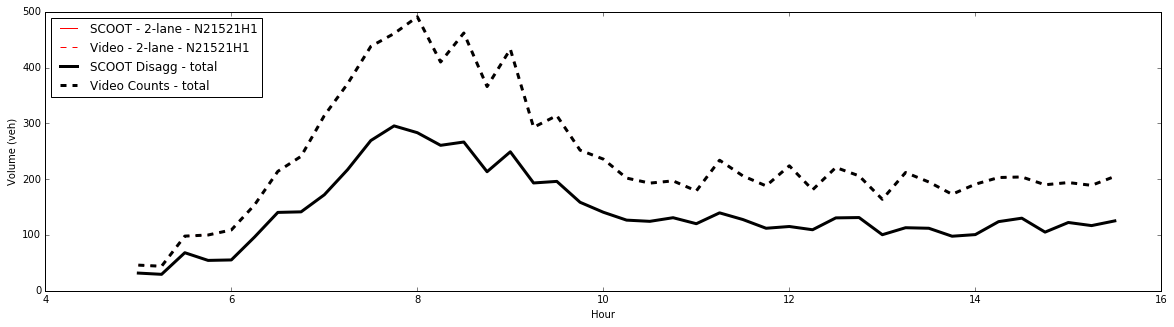

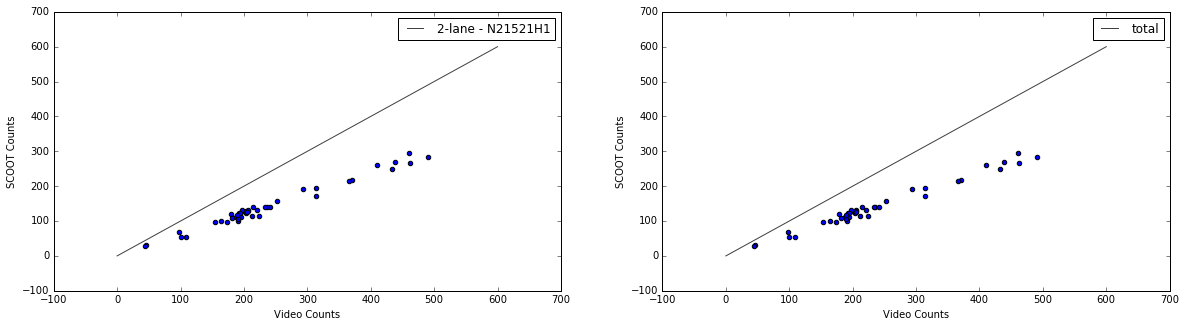

Bloor EB E of Church
binsize = 900 seconds, Video Offset = 0 sec


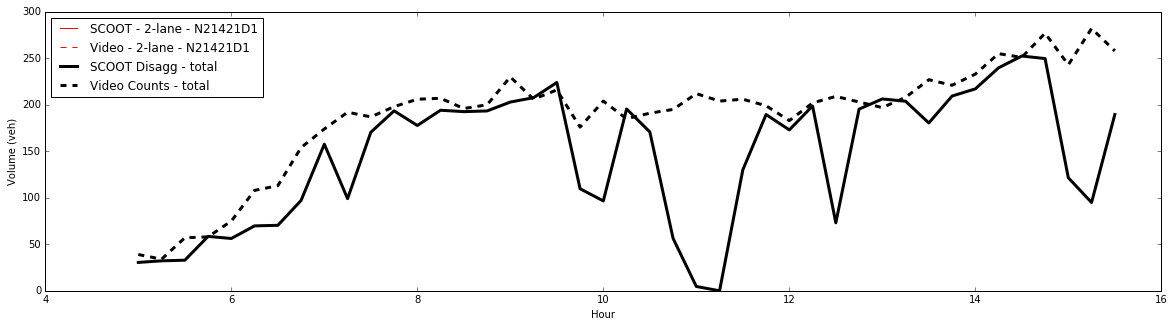

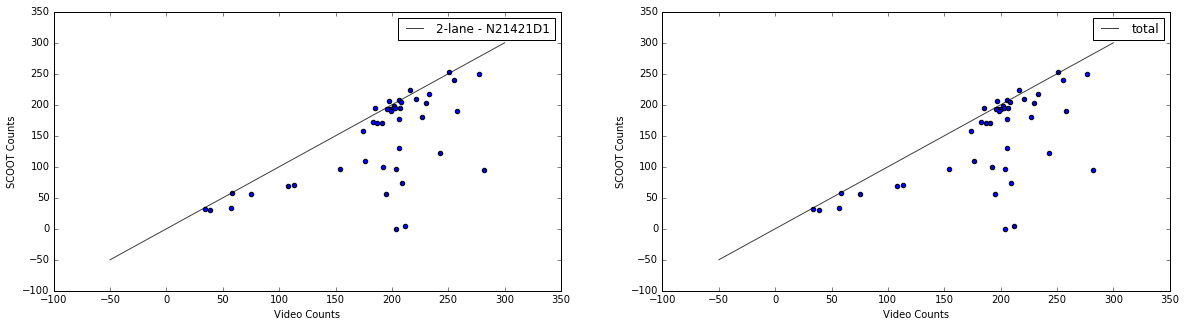

Bloor WB W of Church
binsize = 900 seconds, Video Offset = 0 sec


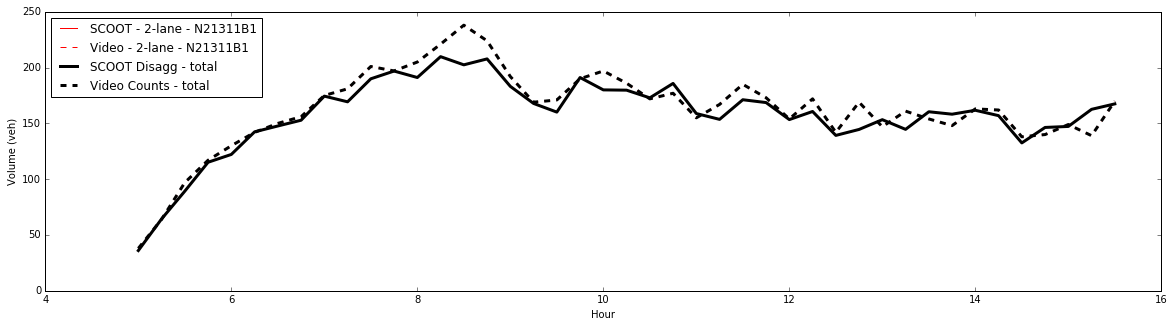

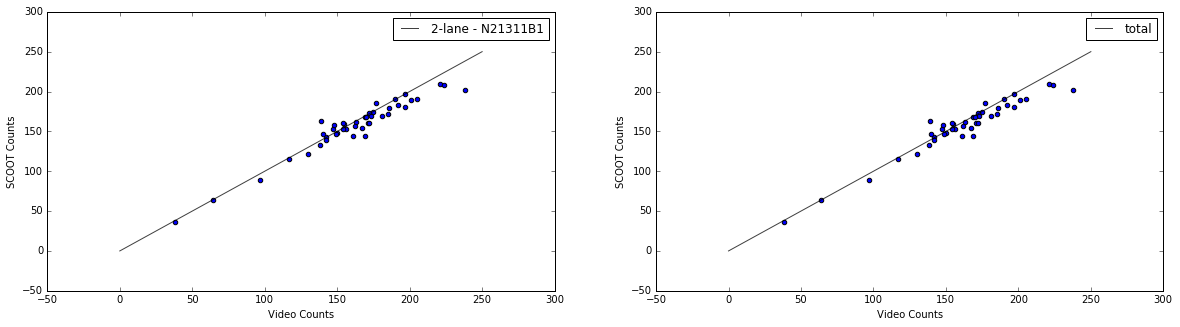

In [13]:
bin_sec_s=[900]
start_hour = 5
start_min = 0
start_sec = 0
end_hour = 15
end_min = 59
end_sec = 59

start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec
s = scoot.copy()
s.reset_index(inplace=True,drop=True)

offsets = [0,0,0,0,0,0,0,0,0,0,0,0]


for i in range(len(locations)):

    sdet = [x.strip('\'') for x in sdetectors[i]]
    tcl = centrelines[i]
    dir_bin = dir_bins[i]
    offset = offsets[i]
    
    # Filter relevant data
    r = video.copy()
    r = r[(r['centreline_id']==tcl) & (r['dir_bin']==dir_bin)]
    s = scoot[scoot['detector'].isin([x.strip('\'') for x in sdet])].copy()
    # Offset video 
    r['seconds']=r['seconds']+offset
    
    print(locations[i])

    for bin_sec in bin_sec_s:
        print('binsize =', bin_sec , 'seconds, Video Offset =', offset, 'sec')
        fig,axx = plt.subplots(figsize=(20,5))

        num_bins = (end_time_sec - start_time_sec)//bin_sec
        min_bins_start = list(np.linspace(start_time_sec, start_time_sec+bin_sec*num_bins, num_bins+1))
        
        # Create bin index
        r['bin'] = r['seconds']//bin_sec
        # Aggregate individual detectors
        r = aggregate_lanes(r, aggregation[i])
    
        r['seconds'] = r['bin']*bin_sec
        r = r[(r['seconds']>=start_time_sec) & (r['seconds']<=(end_time_sec-bin_sec))]
        min_bins_start = [x for x in min_bins_start if (x in list(r['seconds']) or x==start_time_sec+bin_sec*num_bins)]
        r0 = r.groupby(['centreline_id','dir_bin','count_date','bin'], as_index=False).sum()

        fig,(ax) = plt.subplots(1,len(sdet)+1,figsize=(20,5))

        for det in range(len(sdet)):

            v = aggregate_data(min_bins_start, s[s['detector'] == sdet[det]],'Volume')
            axx.plot([x/3600 for x in min_bins_start[:-1]],v,colors[det],label='SCOOT - ' + str(det_lane[sdet[det]]) + '-lane - '+ sdet[det])
            axx.plot([x/3600 for x in min_bins_start[:-1]],r0['detector'+str(det)],colors[det]+'--',label='Video - ' + str(det_lane[sdet[det]]) + '-lane - '+ sdet[det])

            ax[det].scatter(r0['detector'+str(det)],v)
            ax[det].set_xlabel('Video Counts')
            ax[det].set_ylabel('SCOOT Counts')
            add_y_eq_x(ax[det], str(det_lane[sdet[det]]) + '-lane - '+ sdet[det])
            ax[det].legend()

        s0 = s.groupby(['seconds','CycleTime'], as_index=False).sum()
        v = aggregate_data(min_bins_start, s0, 'Volume')
        
        det = det + 1
        axx.plot([x/3600 for x in min_bins_start[:-1]],v,colors[-1], label='SCOOT Disagg - total',linewidth=3)
        axx.plot([x/3600 for x in min_bins_start[:-1]],r0['Volume'],colors[-1]+'--', label='Video Counts - total', linewidth=3)

        ax[det].scatter(r0['Volume'],v)
        ax[det].set_xlabel('Video Counts')
        ax[det].set_ylabel('SCOOT Counts')
        add_y_eq_x(ax[det], 'total')
        ax[det].legend()

        axx.set_ylabel('Volume (veh)')
        axx.set_xlabel('Hour')
        axx.legend(loc=2)
        plt.show()

## Observations
1. When aggregated to 15min bins, the most of the 1-lane detectors follow the line y=x closely. 
2. As noted above, the 2-lane detectors starts to flatten out once a threshold is reached. The threshold and slope vary from detector to detector but for most detectors it starts to deviate at around 150-200 vehicles/15min.

## Conclusion

The detections coming from one-lane detectors can be treated directly as volume. But the detections from two-lane detectors need some fitting once it reaches a threshold. Several models can be fitted to the curve, such as polynomial, log, etc. Some fitting can be done to experiment with the form and the fit. From the plots, the threshold varies from detector to detector.  Ideally a custom fit should be done for every detector. 

Be aware of faulty detectors if the whole process is automated. The city does not seem to be actively maintaining these loops.